In [2]:
%matplotlib inline  
from fastai.vision import *
from fastai.data_block import _maybe_squeeze
from fastai.callbacks import *
from sklearn.model_selection import StratifiedKFold
from joblib import load, dump
from efficientnet_pytorch import EfficientNet
from ranger import *

In [3]:
def strt_split(x, y, n_folds=5, random_seed = 42, path=Path('')):  
    try: 
        val_name = load('val_idx.joblib')
    except:
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
        val_name = [(val_idx, trn_idx) for trn_idx, val_idx in skf.split(x, y)]
        dump(val_name,'val_idx.joblib')
    return val_name

def modified_label_from_df(self, cols:IntsOrStrs=1, label_cls:Callable=None, **kwargs):
    "Label `self.items` from the values in `cols` in `self.inner_df`."
    self.inner_df.labels.fillna('', inplace=True)
    labels = self.inner_df.iloc[:,df_names_to_idx(cols, self.inner_df)]
    assert labels.isna().sum().sum() == 0, f"You have NaN values in column(s) {cols} of your dataframe, please fix it."
    if is_listy(cols) and len(cols) > 1 and (label_cls is None or label_cls == MultiCategoryList):
        new_kwargs,label_cls = dict(one_hot=True, classes= cols),MultiCategoryList
        kwargs = {**new_kwargs, **kwargs}
    return self._label_from_list(_maybe_squeeze(labels), label_cls=label_cls, **kwargs)

In [7]:
PATH = Path('..')
FOLD =0
EXP_NAME =      f'NB_EXP_00_CV_{FOLD}'
IMG_TRAIN_224 = PATH/'train_images_224'
IMG_TEST_224  = PATH/'test_images_224'
DF_TRAIN =      pd.read_csv(PATH/'train_labels_as_strings.csv')
DF_SUBMI =      pd.read_csv(PATH/'stage_1_sample_submission.csv')
BS =            512
SZ =            224



DF_SUBMI['fn'] = DF_SUBMI.ID.apply(lambda x: '_'.join(x.split('_')[:2]) + '.png')
DF_TRAIN['labels'].fillna('', inplace=True)
VAL_IDX = strt_split(DF_TRAIN['fn'], DF_TRAIN['labels'])[FOLD]

In [8]:
ItemList.label_from_df = modified_label_from_df
test_fns = DF_SUBMI.fn.unique()

data = (ImageList.from_csv('..', 'train_labels_as_strings.csv', folder=IMG_TRAIN_224.name)
        .split_by_idxs(valid_idx=VAL_IDX[0], train_idx=VAL_IDX[1])
        .label_from_df(label_delim=' ')
        .transform(tfms = get_transforms(),size=SZ)
        .add_test('../' +IMG_TEST_224.name + '/' + test_fns)
        .databunch(bs=BS))

        

In [9]:
md_ef =  EfficientNet.from_pretrained('efficientnet-b0', num_classes=data.c)

Loaded pretrained weights for efficientnet-b0


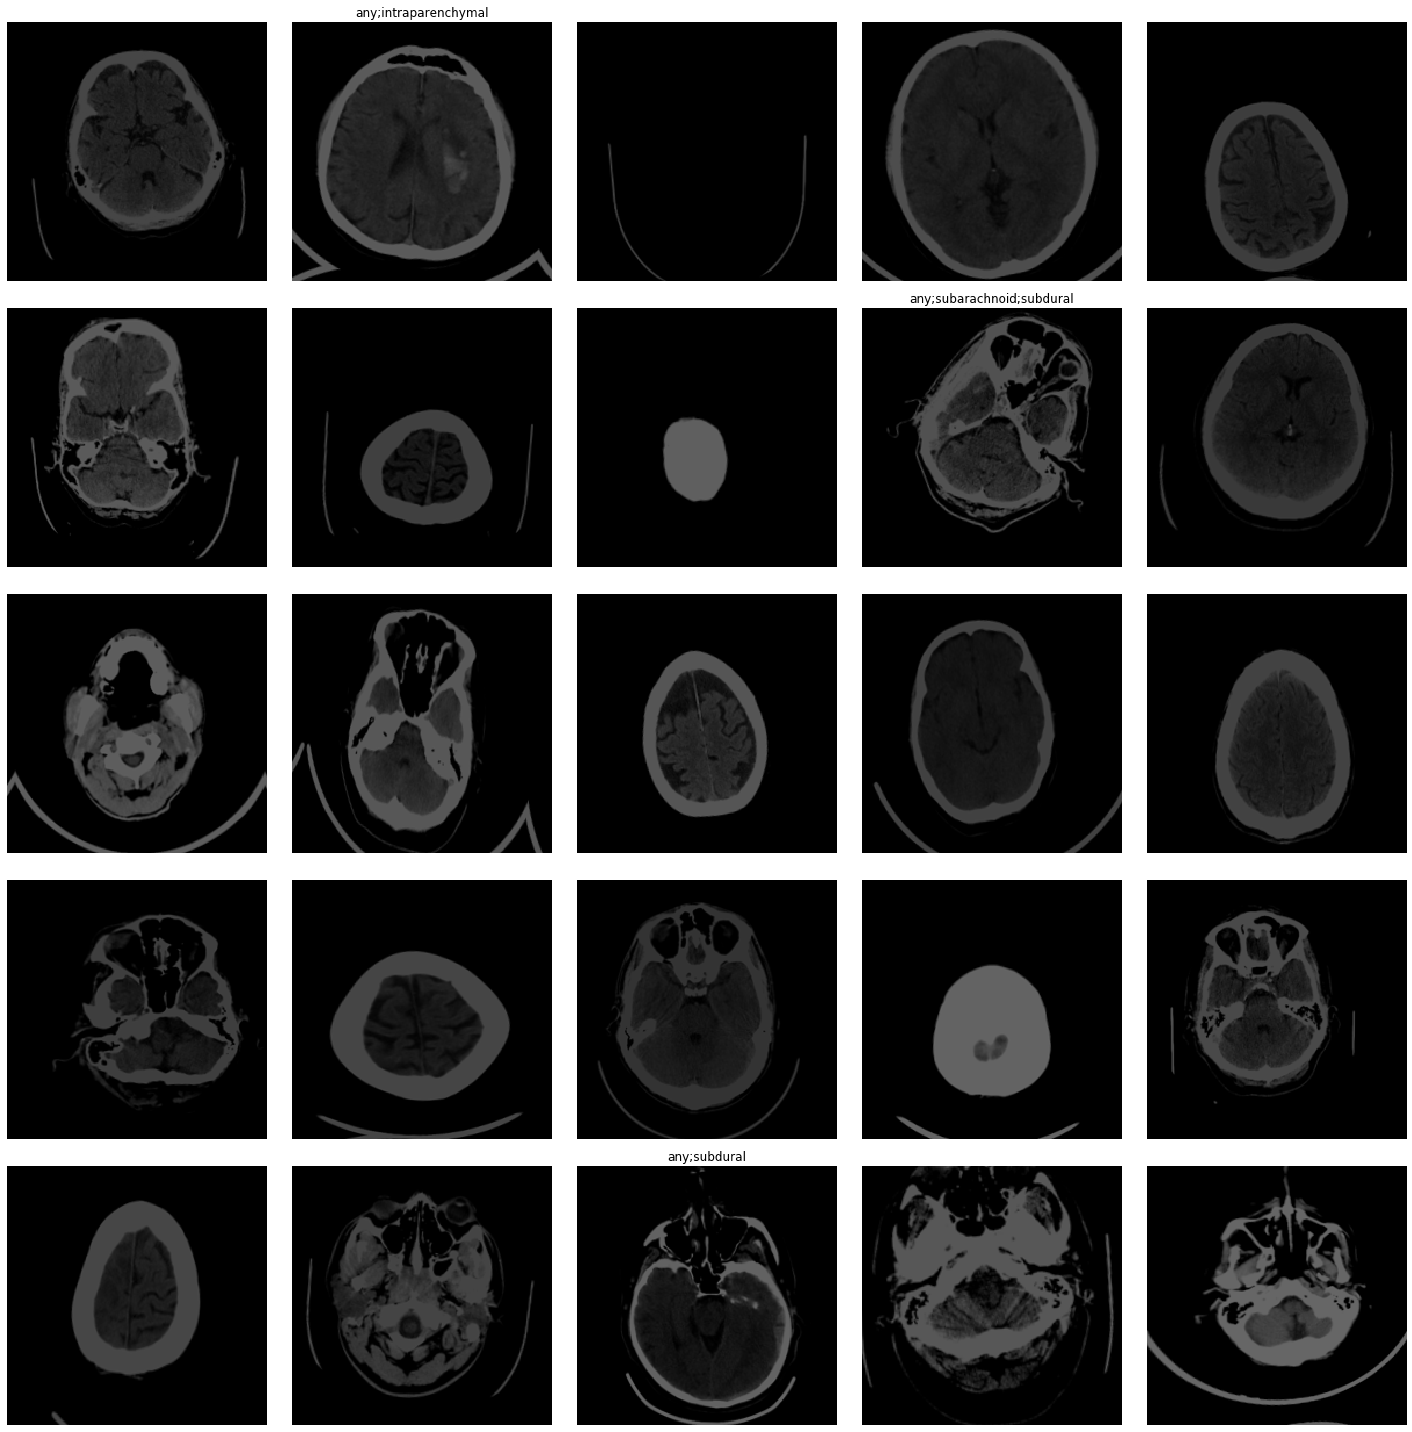

In [9]:
data.show_batch()

In [ ]:
learn = Learner(data,
                md_ef,
                wd=1e-2,
                bn_wd=False, 
                true_wd=True, 
                metrics=[accuracy_thresh])

learn.model = nn.DataParallel(learn.model)
learn.to_fp16()
learn.unfreeze()
learn.lr_find()

In [ ]:
lr = 1e-2/3
learn.recorder.plot()
plt.axvline(lr)

In [9]:
SUFFIX = 'UNFRZ'
learn.fit_one_cycle(5,
                    lr, 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss', name = f'{EXP_NAME}_{SUFFIX}')])

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.089397,0.099770,0.965693,13:39
1,0.081268,0.084128,0.970164,13:29
2,0.072597,0.077943,0.972361,13:26
3,0.064133,0.066598,0.976182,13:27
4,0.061395,0.062080,0.977486,13:26


Better model found at epoch 0 with valid_loss value: 0.09977027028799057.
Better model found at epoch 1 with valid_loss value: 0.08412795513868332.
Better model found at epoch 2 with valid_loss value: 0.07794294506311417.
Better model found at epoch 3 with valid_loss value: 0.06659775227308273.
Better model found at epoch 4 with valid_loss value: 0.06208014488220215.


In [15]:
opt_func = partial(Ranger, betas=(0.95,0.99), eps=1e-6)
learn.opt_func = opt_func

def flattenAnneal(learn:Learner, lr:float, n_epochs:int, start_pct:float, SUFFIX = 'PHASE_2_COS'):
    n = len(learn.data.train_dl)
    anneal_start = int(n*n_epochs*start_pct)
    anneal_end = int(n*n_epochs) - anneal_start
    phases = [TrainingPhase(anneal_start).schedule_hp('lr', lr),
             TrainingPhase(anneal_end).schedule_hp('lr', lr, anneal=annealing_cos)]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    learn.callbacks.append(SaveModelCallback(learn, every='improvement', monitor='valid_loss', name = f'{EXP_NAME}_{SUFFIX}'))
    learn.fit(n_epochs)

In [16]:
lr = 1e-3/8
learn.unfreeze()
flattenAnneal(learn, lr, 20, 0.7)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.060718,0.061868,0.977736,13:30
1,0.057577,0.061768,0.977694,13:29
2,0.057874,0.061478,0.977787,13:30
3,0.058332,0.061484,0.977763,13:27
4,0.057336,0.061066,0.977961,13:27
5,0.057714,0.061197,0.977914,13:24
6,0.056493,0.060959,0.978050,13:28
7,0.056130,0.060618,0.978186,13:28
8,0.056244,0.060639,0.978099,13:28
9,0.056359,0.060289,0.978213,13:31


Better model found at epoch 0 with valid_loss value: 0.06186801567673683.
Better model found at epoch 1 with valid_loss value: 0.06176801025867462.
Better model found at epoch 2 with valid_loss value: 0.06147768348455429.
Better model found at epoch 4 with valid_loss value: 0.061066124588251114.
Better model found at epoch 6 with valid_loss value: 0.060958538204431534.
Better model found at epoch 7 with valid_loss value: 0.060617595911026.
Better model found at epoch 9 with valid_loss value: 0.06028920039534569.
Better model found at epoch 12 with valid_loss value: 0.06006750091910362.
Better model found at epoch 14 with valid_loss value: 0.05981726944446564.
Better model found at epoch 15 with valid_loss value: 0.059605762362480164.
Better model found at epoch 17 with valid_loss value: 0.059520624577999115.
set state called


In [10]:
learn = Learner(data,
                md_ef,
                wd=1e-2,
                bn_wd=False, 
                true_wd=True, 
                metrics=[accuracy_thresh])

learn.model = nn.DataParallel(learn.model)
learn.load('NB_EXP_00_CV_0_PHASE_2_COS')
learn.to_fp16()
learn.unfreeze()
#learn.lr_find()

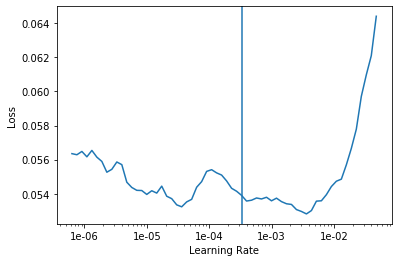

In [14]:
lr = 1e-3/3
learn.recorder.plot()
plt.axvline(lr)

In [11]:
def get_preds(learn:Learner, sub_fn: str=f'{EXP_NAME}_COS', TTA: bool = False, dt_type = DatasetType.Test):
    if TTA:
        learn.to_fp32()
        preds, targs = learn.TTA(ds_type=dt_type)
        sub_fn = f'{sub_fn}_TTA'
    else:
        preds, targs = learn.get_preds(dt_type)
    ids = []
    labels = []

    for fn, pred in zip(test_fns, preds):
        for i, label in enumerate(data.train_ds.classes):
            ids.append(f"{fn.split('.')[0]}_{label}")
            predicted_probability = '{0:1.10f}'.format(pred[i].item())
            labels.append(predicted_probability)
    pd.DataFrame({'ID': ids, 'Label': labels}).to_csv(f'{sub_fn}.csv', index=False)

In [12]:
get_preds(learn, TTA=True)